In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn

In [3]:
raw_data = pd.read_csv("raw_data.csv", parse_dates=[0], index_col=0)

In [4]:
raw_data.head()

,pm25,t2m,d2m,u10,v10
2016-01-01 08:00:00,106,266.158697,262.942797,0.610000,-0.854401
2016-01-01 14:00:00,172,277.572013,265.854378,0.539951,0.014327
2016-01-01 20:00:00,260,271.109503,266.588183,1.231592,-0.007235
2016-01-02 02:00:00,306,266.704619,264.173029,0.891609,-1.404387
2016-01-02 08:00:00,195,266.042011,262.649275,0.834297,-1.433449


In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
data = series_to_supervised(raw_data,4,1)
data.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2016-01-02 08:00:00,106.0,266.158697,262.942797,0.610000,-0.854401,172.0,277.572013,265.854378,0.539951,0.014327,...,306.0,266.704619,264.173029,0.891609,-1.404387,195,266.042011,262.649275,0.834297,-1.433449
2016-01-02 14:00:00,172.0,277.572013,265.854378,0.539951,0.014327,260.0,271.109503,266.588183,1.231592,-0.007235,...,195.0,266.042011,262.649275,0.834297,-1.433449,210,279.451486,266.322240,-0.287542,-0.858151
2016-01-02 20:00:00,260.0,271.109503,266.588183,1.231592,-0.007235,306.0,266.704619,264.173029,0.891609,-1.404387,...,210.0,279.451486,266.322240,-0.287542,-0.858151,416,273.128582,265.770655,-0.589317,-1.276265
2016-01-03 02:00:00,306.0,266.704619,264.173029,0.891609,-1.404387,195.0,266.042011,262.649275,0.834297,-1.433449,...,416.0,273.128582,265.770655,-0.589317,-1.276265,482,268.245495,264.837886,-0.198389,-1.861250
2016-01-03 08:00:00,195.0,266.042011,262.649275,0.834297,-1.433449,210.0,279.451486,266.322240,-0.287542,-0.858151,...,482.0,268.245495,264.837886,-0.198389,-1.861250,178,267.091140,264.431092,-0.402167,-1.321264


In [7]:
values = data.values

In [13]:
# n_train_samples = 1000
# n_test_samples = 500
# train = values[:n_train_samples, :]
# test = values[-n_test_samples:, :]
rmse_list = []
for i in range(10):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :20]
    train_y = train[:,20]
    test_X = test[:, :20]
    test_y = test[:,20]
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y)
    y_predict = reg.predict(test_X)
    m = mean_squared_error(y_predict, test_y)
    RMSE = math.sqrt(m)
    rmse_list.append(RMSE)
print(np.mean(rmse_list))

48.26247826825299


In [14]:
train.shape

(2131, 25)

In [15]:
test.shape

(533, 25)

In [16]:
train_X.shape

(2131, 20)

In [17]:
train_y.shape

(2131,)

In [18]:
test_X.shape

(533, 20)

In [19]:
test_y.shape

(533,)

In [21]:
y_predict = reg.predict(test_X)
y_predict

array([ 19.35994883,  16.84108961,  54.98743422,  71.83196876,
        -1.75671512, 184.18916297, 156.74156814,  83.28149238,
        45.39153366,  31.00047289,  -3.14161475,  18.4079762 ,
       164.33118397,  28.78092976, 106.9136819 ,  -4.73684592,
        -2.95173512,  72.48696768,  30.35349266,  31.50120146,
        47.17132183, 258.44032747,  11.41680281,  69.89645891,
        62.40707095, 111.22516559,  -7.55828382,  42.36338253,
       122.2044513 ,  96.92450815,  82.20569844,  42.11979082,
        66.96361389,  80.59606763,  69.04992499,  53.45997581,
       145.59156362,   3.81859407,  43.74867489,  86.69463395,
       110.29449308,  78.20837181,  46.35261429, 297.28278682,
        84.35164808, 135.21273531, 261.31158726,  89.99368599,
       148.98468493, -12.95039838,  33.88410722,  -0.59562929,
       112.75497622,  82.47015631,  68.40817032, 147.6211372 ,
        88.6668018 , 132.70473416,  68.54440343,   8.77852521,
        80.7239121 , 155.42423546,  50.62497273,  19.77

In [15]:
y_predict.shape

(533,)

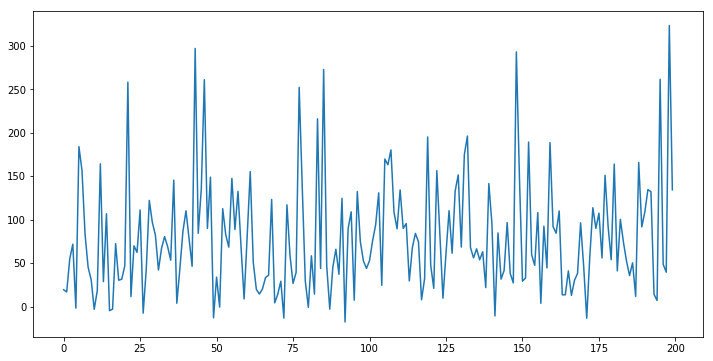

In [34]:
plt.plot(np.arange(len(y_predict[:200])), y_predict[:200])

In [17]:
np.arange(len(y_predict))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

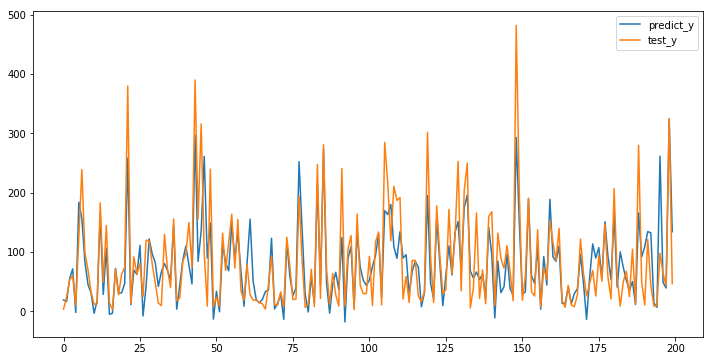

In [33]:
plt.plot(np.arange(len(y_predict[:200])), y_predict[:200], label = "predict_y")
plt.plot(np.arange(len(y_predict[:200])), test_y[:200], label = "test_y")
plt.legend()
plt.show()

# SVR 

In [140]:
from sklearn import svm

In [42]:
# n_train_samples = 1000
# n_test_samples = 500
# train = values[:n_train_samples, :]
# test = values[-n_test_samples:, :]

# Grid search 
rmse_list = []
C_list = [1e3, 2e3, 3e3]
gamma_list = [1e-6, 2e-6, 3e-6]
rmse_matrix = np.zeros((len(C_list), len(gamma_list)))
for i in range(1):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :20]
    train_y = train[:,20]
    test_X = test[:, :20]
    test_y = test[:,20]
    for c_index, c in enumerate(C_list):
        for g_index, g in enumerate(gamma_list):
            print(c_index)
            print(g_index)
            clf = svm.SVR(kernel='rbf', C=c, gamma=g)
            clf.fit(train_X, train_y)
            print("completed training")
            y_predict = clf.predict(test_X)
            print("completed predicting")
            RMSE = math.sqrt(mean_squared_error(y_predict, test_y)) 
            
            rmse_matrix[c_index, g_index] = RMSE
print(rmse_matrix)

0
0
completed training
completed predicting
0
1
completed training
completed predicting
0
2
completed training
completed predicting
1
0
completed training
completed predicting
1
1
completed training
completed predicting
1
2
completed training
completed predicting
2
0
completed training
completed predicting
2
1
completed training
completed predicting
2
2
completed training
completed predicting
[[48.11267053 48.36071421 48.44239332]
 [47.85899336 48.22636603 48.6030643 ]
 [47.83655538 48.15404988 48.89705084]]


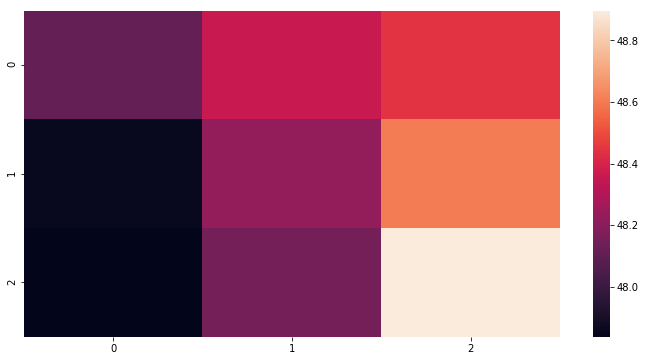

In [43]:
seaborn.heatmap(rmse_matrix)

In [92]:
train, test = train_test_split(values, test_size=0.2)
train_X = train[:, :20]
train_y = train[:,20]
test_X = test[:, :20]
test_y = test[:,20]
clf = svm.SVR(kernel='rbf', C=1e3, gamma=2e-6)
clf.fit(train_X, train_y)
print("completed training")
y_predict = clf.predict(test_X)
print("completed predicting")
RMSE = math.sqrt(mean_squared_error(y_predict, test_y)) 
print(RMSE)

completed training
completed predicting
47.13651960860277


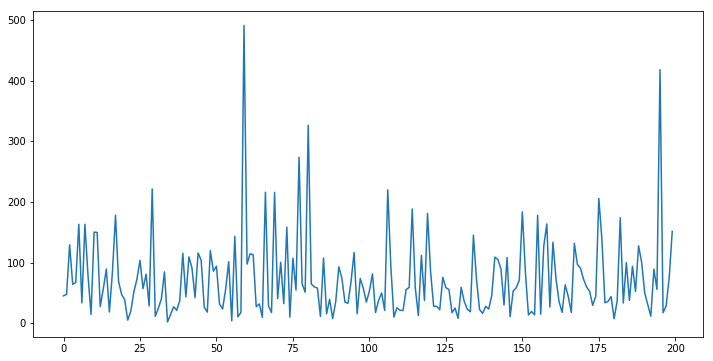

In [54]:
plt.plot(np.arange(len(y_predict[:200])), y_predict[:200])

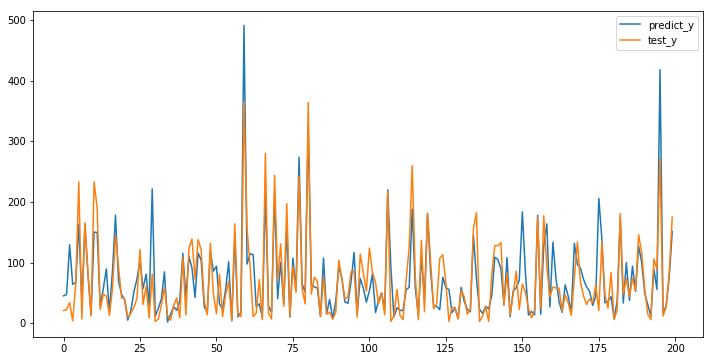

In [56]:
plt.plot(np.arange(len(y_predict[:200])), y_predict[:200], label = "predict_y")
plt.plot(np.arange(len(y_predict[:200])), test_y[:200], label = "test_y")
plt.legend()
plt.show()

# raw_data,8,3

## 1. linear regression

In [104]:
data = series_to_supervised(raw_data,8,3)
data.head()

,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),...,var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2)
2016-01-03 08:00:00,106.0,266.158697,262.942797,0.610000,-0.854401,172.0,277.572013,265.854378,0.539951,0.014327,...,119.0,276.285346,265.808084,-0.042372,-1.107519,239.0,271.418928,266.042508,-0.008763,-0.415975
2016-01-03 14:00:00,172.0,277.572013,265.854378,0.539951,0.014327,260.0,271.109503,266.588183,1.231592,-0.007235,...,239.0,271.418928,266.042508,-0.008763,-0.415975,251.0,268.203821,263.281628,0.575683,-1.850000
2016-01-03 20:00:00,260.0,271.109503,266.588183,1.231592,-0.007235,306.0,266.704619,264.173029,0.891609,-1.404387,...,251.0,268.203821,263.281628,0.575683,-1.850000,10.0,266.343102,259.246193,0.205982,-1.991872
2016-01-04 02:00:00,306.0,266.704619,264.173029,0.891609,-1.404387,195.0,266.042011,262.649275,0.834297,-1.433449,...,10.0,266.343102,259.246193,0.205982,-1.991872,13.0,273.387999,257.919434,0.412236,-2.089369
2016-01-04 08:00:00,195.0,266.042011,262.649275,0.834297,-1.433449,210.0,279.451486,266.322240,-0.287542,-0.858151,...,13.0,273.387999,257.919434,0.412236,-2.089369,18.0,269.832212,256.768985,-0.143200,-2.316863


In [105]:
values = data.values

In [130]:
rmse_list = []
for i in range(10):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :40]
    train_y1 = train[:,40]
    test_X = test[:, :40]
    test_y1 = test[:,40]
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y1)
    y_predict1 = reg.predict(test_X)
    m1 = mean_squared_error(y_predict1, test_y1)
    RMSE1 = math.sqrt(m1)
    rmse_list.append(RMSE1)
print(np.mean(rmse_list))

46.47728553183694


In [131]:
rmse_list = []
for i in range(10):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :40]
    train_y2 = train[:,45]
    test_X = test[:, :40]
    test_y2 = test[:,45]
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y2)
    y_predict2 = reg.predict(test_X)
    m2 = mean_squared_error(y_predict2, test_y2)
    RMSE2 = math.sqrt(m2)
    rmse_list.append(RMSE2)
print(np.mean(rmse_list))

60.331500067130754


In [132]:
rmse_list = []
for i in range(10):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :40]
    train_y3 = train[:,50]
    test_X = test[:, :40]
    test_y3 = test[:,50]
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y3)
    y_predict3 = reg.predict(test_X)
    m3 = mean_squared_error(y_predict3, test_y3)
    RMSE3 = math.sqrt(m3)
    rmse_list.append(RMSE3)
print(np.mean(rmse_list))

64.37844017798264


In [133]:
train_X.shape

(2126, 40)

In [134]:
train_y.shape

(2126,)

In [135]:
test_X.shape

(532, 40)

In [136]:
test_y.shape

(532,)

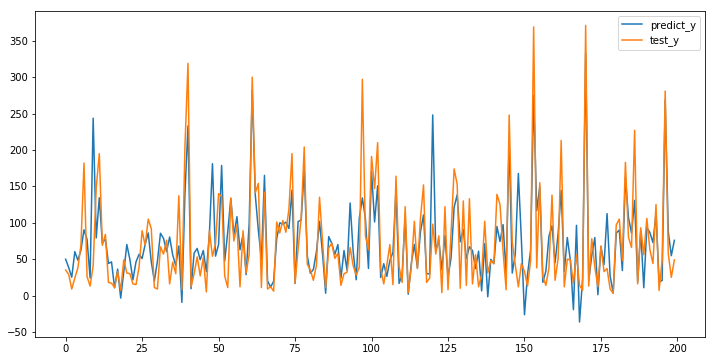

In [137]:
plt.plot(np.arange(len(y_predict1[:200])), y_predict1[:200], label = "predict_y")
plt.plot(np.arange(len(y_predict1[:200])), test_y1[:200], label = "test_y")
plt.legend()
plt.show()

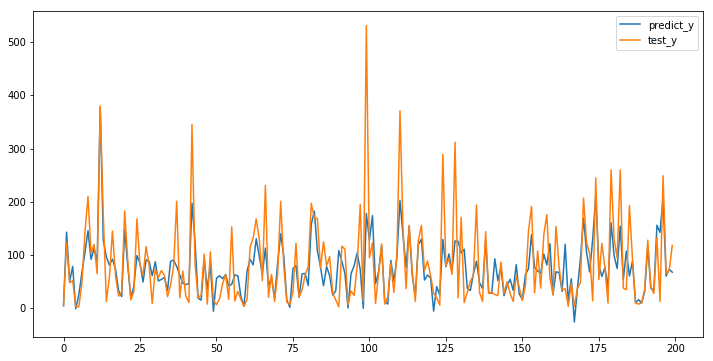

In [138]:
plt.plot(np.arange(len(y_predict2[:200])), y_predict2[:200], label = "predict_y")
plt.plot(np.arange(len(y_predict2[:200])), test_y2[:200], label = "test_y")
plt.legend()
plt.show()

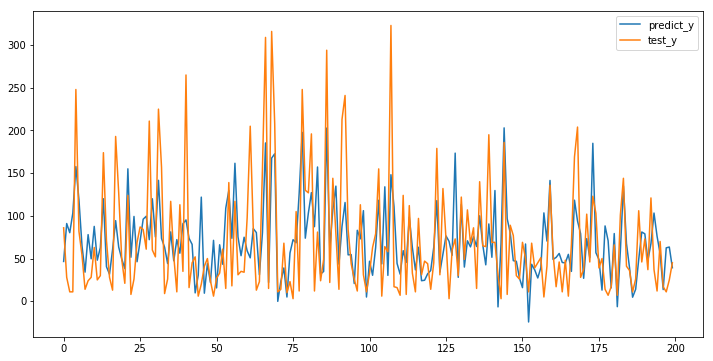

In [139]:
plt.plot(np.arange(len(y_predict3[:200])), y_predict3[:200], label = "predict_y")
plt.plot(np.arange(len(y_predict3[:200])), test_y3[:200], label = "test_y")
plt.legend()
plt.show()

## 2.SVM

In [150]:
rmse_list = []
C_list = [1, 10, 1e2]
gamma_list = [1, 1e-1, 1e-2]
rmse_matrix = np.zeros((len(C_list), len(gamma_list)))
for i in range(1):
    train, test = train_test_split(values, test_size=0.2)
    train_X = train[:, :40]
    train_y1 = train[:,40]
    test_X = test[:, :40]
    test_y1 = test[:,40]
    for c_index, c in enumerate(C_list):
        for g_index, g in enumerate(gamma_list):
            print(c_index)
            print(g_index)
            clf = svm.SVR(kernel='rbf', C=c, gamma=g)
            clf.fit(train_X, train_y1)
            print("completed training")
            y_predict = clf.predict(test_X)
            print("completed predicting")
            RMSE1 = math.sqrt(mean_squared_error(y_predict1, test_y1)) 
            
            rmse_matrix[c_index, g_index] = RMSE1
print(rmse_matrix)

0
0
completed training
completed predicting
0
1
completed training
completed predicting
0
2
completed training
completed predicting
1
0
completed training
completed predicting
1
1
completed training
completed predicting
1
2
completed training
completed predicting
2
0
completed training
completed predicting
2
1
completed training
completed predicting
2
2
completed training
completed predicting
[[91.57728394 91.57728394 91.57728394]
 [91.57728394 91.57728394 91.57728394]
 [91.57728394 91.57728394 91.57728394]]


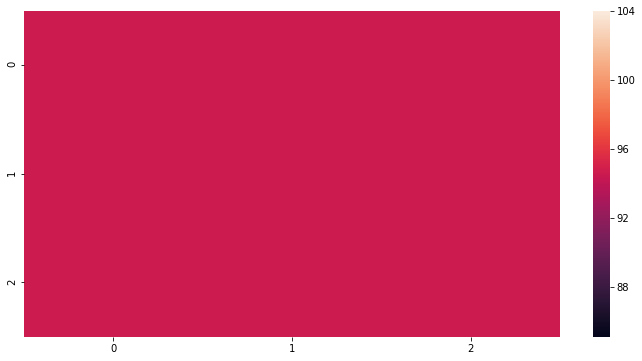

In [148]:
seaborn.heatmap(rmse_matrix)